# Setup

In [ ]:
#@title ## Base imports
import os
import cmd
import sys
import json
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import sklearn.calibration
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf

import sklearn.metrics

import skimage
import skimage.io
import PIL
import PIL.Image
import requests

import IPython.display
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots

# Display versions of python packages
pip_versions = %system pip freeze  # uses colab magic to get list from shell
pip_versions_organized = {
    "standard": [pip_version for pip_version in pip_versions if "==" in pip_version],
    "other": [pip_version for pip_version in pip_versions if "==" not in pip_version]
    }
print(f"Python version: {sys.version} \n")  # display version of python itself (i.e. 3.8.10)
cli = cmd.Cmd()
cli.columnize(pip_versions_organized["standard"], displaywidth=800)
cli.columnize(pip_versions_organized["other"], displaywidth=160)

<IPython.core.display.Javascript object>

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] 

absl-py==1.4.0                autograd==1.6.2         cffi==1.16.0               contourpy==1.2.1       distro==1.7.0             fastcore==1.5.46        gcsfs==2023.6.0                      google-cloud-aiplatform==1.56.0           googledrivedownloader==0.4  humanize==4.7.0             ipykernel==5.5.6                      jupyter-console==6.1.0      lightgbm==4.1.0             mistune==0.8.4           nbformat==5.10.4                   optax==0.2.2                pickleshare==0.7.5         prophet==1.1.5             pydot-ng==2.0.0          pyshp==2.3.1            regex==2024.5.15            sentencepiece==0.1.99           sphinxcontrib-devhelp==1.0.6           tensorboard==2.15.2                   tifffile==2024.6.18                typing_extensions==4.12.2  xarray==2023.7.0      
aiohttp==3.9.5                Babel==2.15.0           chardet==5.2.0             cryptography==42.0.8   dlib==19.24.4             fastd

In [ ]:
colab_ip = %system hostname -I   # uses colab magic to get list from bash
colab_ip = colab_ip[0].strip()   # returns "172.28.0.12"
colab_port = 9000                # could use 6000, 8080, or 9000

notebook_filename = filename = requests.get(f"http://{colab_ip}:{colab_port}/api/sessions").json()[0]["name"]

# Avoids scroll-in-the-scroll in the entire Notebook
def resize_colab_cell():
  display(IPython.display.Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)


#@markdown ### func `def get_path_to_save(...):`
def get_path_to_save(plot_props:dict=None, file_prefix="", save_filename:str=None, save_in_subfolder:str=None, extension="jpg", dot=".", create_folder_if_necessary=True):
    """
    Code created myself (Rahul Yerrabelli)
    """
    replace_characters = {
        "$": "",
        "\\frac":"",
        "\\mathrm":"",
        "\\left(":"(",
        "\\right)":")",
        "\\left[":"[",
        "\\right]":"]",
        "\\": "",
        "/":"-",
        "{": "(",
        "}": ")",
        "<":"",
        ">":"",
        "?":"",
        "_":"",
        "^":"",
        "*":"",
        "!":"",
        ":":"-",
        "|":"-",
        ".":"_",
    }

    # define save_filename based on plot_props
    if save_filename is None:
        save_filename = "unnamed"

    #save_path = f"../outputs/{notebook_filename.split('.',1)[0]}"
    save_path = [
                 "outputs",
                f"{notebook_filename.split('.',1)[0]}",
                ]
    if save_in_subfolder is not None:
        if isinstance(save_in_subfolder, (list, tuple, set, np.ndarray) ):
            save_path.append(**save_in_subfolder)
        else:  # should be a string then
            save_path.append(save_in_subfolder)
    save_path = os.path.join(*save_path)

    if not os.path.exists(save_path) and create_folder_if_necessary:
        os.makedirs(save_path)
    return os.path.join(save_path, file_prefix+save_filename+dot+extension)
    #plt.savefig(os.path.join(save_path, save_filename+dot+extension))



In [ ]:
#@title ## Mount google drive and import my code

mountpoint_folder_name = "drive"  # can be anything, doesn't have to be "drive"
project_path_within_drive = "PythonProjects/ECV-Analysis" #@param {type:"string"}
#project_path_within_drive = "UIUC ECs/Rahul_Ashkhan_Projects/SpeculumProjects_Shared/Analysis" #@param {type:"string"}
project_path_full = os.path.join("/content/",mountpoint_folder_name,
                        "MyDrive",project_path_within_drive)

%cd {project_path_full}

<IPython.core.display.Javascript object>

[Errno 2] No such file or directory: '/content/drive/MyDrive/PythonProjects/ECV-Analysis'
/content


In [ ]:
try:
    import google.colab.drive
    import os, sys
    # Need to move out of google drive directory if going to remount
    %cd
    # drive.mount documentation can be accessed via: drive.mount?
    #Signature: drive.mount(mountpoint, force_remount=False, timeout_ms=120000, use_metadata_server=False)
    google.colab.drive.mount(os.path.join("/content/",mountpoint_folder_name), force_remount=True)  # mounts to a folder called mountpoint_folder_name

    if project_path_full not in sys.path:
        pass
        #sys.path.insert(0,project_path_full)
    %cd {project_path_full}

except ModuleNotFoundError:  # in case not run in Google colab
    import traceback
    traceback.print_exc()

<IPython.core.display.Javascript object>

/root
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1okL5s1HTQUWqKodPSVNP_RsK0o81IH5E/PythonProjects2/ECV-Analysis


# Data processing

## Load processed data (created in other notebook)

In [ ]:
all_records_by_pt_df = pd.read_pickle("data/02_processed/all_records_by_pt_df"+".pkl")

proc_records_by_pt_df = pd.read_pickle("data/02_processed/proc_records_by_pt_df"+".pkl")

proc_records_by_ecv_df = pd.read_pickle("data/02_processed/proc_records_by_ecv_df"+".pkl")


<IPython.core.display.Javascript object>

# Demographics table

BMI, Age, GA at delivery, parity, success, TWG

## Numerics

In [ ]:
proc_records_by_pt_df.columns

<IPython.core.display.Javascript object>

Index(['Skip', 'ECV Done?', 'Presentation Brief', 'Presentation Detail',
       'Placenta Location', 'Placenta Grade', 'AFI equiv', 'AFI', 'SDP1',
       'SDP', 'Fetal Spine', 'US EFW (g)', 'US EFW (%)', 'ECV EFW (g)',
       'Delivery EFW (g)', 'ECV GA', 'ECV to Delivery (days)', 'Delivery GA',
       'Delivery Type Brief', 'Delivery Type Detail', 'Delivery Type Ct',
       'Notes', 'age_delivery', 'first_bmi', 'first_weight', 'last_bmi',
       'delivery_bmi', 'delivery_weight', 'twg', 'ethnicity',
       'patient_race___1', 'patient_race___2', 'patient_race___3',
       'patient_race___4', 'patient_race___5', 'patient_race___6',
       'patient_race___7', 'patient_race___8', 'patient_race___9',
       'language_c', 'interpreter_needed_yn', 'baby_gender_1', 'baby_status_1',
       'baby_gender_2', 'baby_status_2', 'gravida_this_pregnancy',
       'para_this_pregnancy', 'term_this_pregnancy', 'preterm_this_pregnancy',
       'rupture_membranes', 'gravida_prev_preg_1', 'gravida_prev_pr

In [ ]:
key_numeric_cols = proc_records_by_pt_df[[
    "age_delivery","para_this_pregnancy",
    "ECV GA", "Delivery GA", "ECV to Delivery (days)",
    "first_bmi", "last_bmi","delivery_weight",
    "AFI equiv","AFI",
    'US EFW (g)', 'US EFW (%)', 'ECV EFW (g)',
       'Delivery EFW (g)'
    ]]

pd.concat([
    pd.DataFrame.from_dict({"ct":key_numeric_cols.count()}, orient="index"), # count(.) counts not nan,  from_dict just converts series to df
    key_numeric_cols.apply([np.mean, np.std]),
    key_numeric_cols.quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])
    ], axis=0).T


<IPython.core.display.Javascript object>

,ct,mean,std,0.0,0.1,0.25,0.5,0.75,0.9,1.0
age_delivery,125.0,30.224,4.946266,18.0,23.4,28.0,30.0,34.0,36.0,40.0
para_this_pregnancy,125.0,1.048,1.169891,0.0,0.0,0.0,1.0,2.0,3.0,5.0
ECV GA,125,265.424,6.437371,256.0,259.0,260.0,263.0,270.0,274.6,286.0
Delivery GA,125.0,275.048,6.025291,260.0,266.4,273.0,275.0,278.0,283.0,290.0
ECV to Delivery (days),125,9.624,7.338216,0.0,0.0,1.0,10.0,15.0,18.0,27.0
first_bmi,124.0,28.212742,6.773115,17.59,20.7,22.6,26.985,33.29,38.11,46.28
last_bmi,124.0,31.095081,6.268471,19.91,23.982,26.5575,29.985,35.3775,40.354,47.29
delivery_weight,124.0,190.652031,36.408537,127.0,148.3,162.0,187.0,210.0,240.68,311.0
AFI equiv,125.0,14.65192,4.960814,5.73,9.442,11.16,13.68,17.9,22.002,34.97
AFI,120.0,14.667667,5.048544,5.73,9.362,10.9875,13.675,17.9475,22.093,34.97


In [ ]:
key_numeric_cols = proc_records_by_pt_df[[
    "ecv_successful_1",
    "age_delivery","para_this_pregnancy",
    "ECV GA", "Delivery GA", "ECV to Delivery (days)",
    "first_bmi", "last_bmi","delivery_weight",
    "AFI equiv","AFI",
    'US EFW (g)', 'US EFW (%)', 'ECV EFW (g)',
       'Delivery EFW (g)'
    ]]

key_numeric_cols.groupby(["ecv_successful_1"]).agg([np.mean, np.std])


<IPython.core.display.Javascript object>

age_delivery           para_this_pregnancy            \
                         mean       std                mean       std   
ecv_successful_1                                                        
0.0                 29.196721  4.273249            0.672131  0.961272   
1.0                 31.203125  5.363544            1.406250  1.243635   

                      ECV GA           Delivery GA            \
                        mean       std        mean       std   
ecv_successful_1                                               
0.0               264.131148  5.349378  274.000000  4.393177   
1.0                266.65625  7.151909  276.046875  7.141272   

                 ECV to Delivery (days)            ...        AFI            \
                                   mean       std  ...       mean       std   
ecv_successful_1                                   ...                        
0.0                            9.868852  6.168402  ...  14.000678  4.945653   
1.0                            9.390625  8.344977  ...  15.312787  5.103534   

                   US EFW (g)              US EFW (%)            ECV EFW (g)  \
                         mean          std       mean       std         mean   
ecv_successful_1                                                               
0.0               2625.107143  1067.427165   0.497115  0.235625  3123.890311   
1.0               2602.016393   788.436903   0.442500  0.158698  3117.868778   

                             Delivery EFW (g)              
                         std             mean         std  
ecv_successful_1                                           
0.0               325.591895      3432.616681  314.466403  
1.0               274.391980      3418.665749  300.826629  

[2 rows x 28 columns]

### AFV/AFI

In [ ]:
proc_records_by_pt_df[["AFI","SDP","SDP1","AFI equiv"]].isnull().sum()

<IPython.core.display.Javascript object>

AFI            5
SDP          114
SDP1         114
AFI equiv      0
dtype: int64

In [ ]:
proc_records_by_pt_df2 = proc_records_by_pt_df.copy()
proc_records_by_pt_df2["ecv_successful_1"] = proc_records_by_pt_df2["ecv_successful_1"].replace({1.0:"Yes",0.0:"No"})
fig = px.histogram(proc_records_by_pt_df2, x="AFI equiv", color="ecv_successful_1", marginal="box",
                   labels={"AFI equiv":"AFI equivalent","ecv_successful_1":"ECV success (attempt 1)"},
                   color_discrete_map={"Yes":px.colors.qualitative.D3[2],"No":px.colors.qualitative.Plotly[1]},
                   )
fig.update_traces(xbins=dict( # bins used for histogram
                             start=0.0, end=35.0, size=1 ),
                  marker=dict(line=dict(width=2, color="#000") ),
                  selector=dict(type="histogram"))
fig.update_traces(boxpoints="all",selector=dict(type="box"))
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=0.6,
    xanchor="right",
    x=1,
    bordercolor="Black", #font_size=16,
    borderwidth=2,
))
fig.update_layout(font=dict(family="Arial",size=16,),template="simple_white",width=900,height=400)
fig.show()

<IPython.core.display.Javascript object>

In [ ]:
proc_records_by_pt_df2 = proc_records_by_pt_df.copy()
proc_records_by_pt_df2["ecv_successful_1"] = proc_records_by_pt_df2["ecv_successful_1"].replace({1.0:"Yes",0.0:"No"})
fig = px.histogram(proc_records_by_pt_df2, x="AFI equiv", color="ecv_tries", labels={"AFI equiv":"AFI or AFI equivalent","ecv_successful_1":"ECV success (attempt 1)"})
fig.update_traces(xbins=dict( # bins used for histogram
                             start=0.0, end=35.0, size=1 ),
                  marker=dict(line=dict(width=2, color="#000") ),
                  selector=dict(type="histogram"))
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=0.6,
    xanchor="right",
    x=1,
    bordercolor="Black", #font_size=16,
    borderwidth=2,
))
fig.update_layout(font=dict(family="Arial",size=16,),template="simple_white",width=900,height=400)
fig.show()

<IPython.core.display.Javascript object>

### EFW

In [ ]:
np.floor(np.arange(1,7)/2)

<IPython.core.display.Javascript object>

array([0., 1., 1., 2., 2., 3.])

In [ ]:
np.arange(7) + "a"

<IPython.core.display.Javascript object>

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U1')) -> None

In [ ]:
def days_to_wga(total_days):
    wks = np.floor(total_days/7)
    days = total_days % 7
    re

In [ ]:
proc_records_by_pt_df2 = proc_records_by_pt_df.copy()
proc_records_by_pt_df2["ecv_successful_1"] = proc_records_by_pt_df2["ecv_successful_1"].replace({1.0:"Yes",0.0:"No"})
fig = px.histogram(proc_records_by_pt_df2, x="ECV GA", color="ecv_successful_1", marginal="box",
                   labels={"ECV GA":"GA at ECV","ecv_successful_1":"ECV success (attempt 1)"},
                   color_discrete_map={"Yes":px.colors.qualitative.D3[2],"No":px.colors.qualitative.Plotly[1]},
                   )
fig.update_traces(xbins=dict( # bins used for histogram
                             start=36*7, end=41*7, size=3.5
                              ),
                  marker=dict(line=dict(width=2, color="#000") ),
                  selector=dict(type="histogram"))
fig.update_xaxes(
    title="Score",
    #mirror=True,  # mirror=True means only lines are present, not ticks
    range=[36*7+4,41*7],
    tick0=36*7,dtick=7,
    tickmode = "",
    tickvals = np.arange(36,41+1)*7,
    ticktext = ['One', 'Three', 'Five', 'Seven', 'Nine', 'Eleven']
)
fig.update_traces(boxpoints="all",selector=dict(type="box"))
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=0.6,
    xanchor="right",
    x=1,
    bordercolor="Black", #font_size=16,
    borderwidth=2,
))


fig.update_layout(coloraxis_colorbar=dict(
    title="GA at ECV",
    tickvals=[36*7,37*7,38*7,39*7,40*7,41*7],
    ticktext=["36w", "37w", "38w", "39w","40w","41w"],
    orientation="h"
))
fig.update_layout(font=dict(family="Arial",size=16,),template="simple_white",width=900,height=400)
fig.show()

<IPython.core.display.Javascript object>

In [ ]:
proc_records_by_pt_df2 = proc_records_by_pt_df.copy()
proc_records_by_pt_df2["ecv_successful_1"] = proc_records_by_pt_df2["ecv_successful_1"].replace({1.0:"Yes",0.0:"No"})
fig = px.histogram(proc_records_by_pt_df2, x="ECV EFW (g)", color="ecv_successful_1", marginal="box",
                   labels={"ECV EFW (g)":"EFW at ECV (g)","ecv_successful_1":"ECV success (attempt 1)"},
                   color_discrete_map={"Yes":px.colors.qualitative.D3[2],"No":px.colors.qualitative.Plotly[1]},
                   )
fig.update_traces(xbins=dict( # bins used for histogram
                             start=2500, end=4300, size=100
                              ),
                  marker=dict(line=dict(width=2, color="#000") ),
                  selector=dict(type="histogram"))
fig.update_traces(boxpoints="all",selector=dict(type="box"))
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="top",
    y=0.6,
    xanchor="right",
    x=1,
    bordercolor="Black", #font_size=16,
    borderwidth=2,
))
fig.update_layout(font=dict(family="Arial",size=16,),template="simple_white",width=900,height=400)
fig.show()

## Categorical data

In [ ]:
yes_no_values = {
    0: "No",
    1: "Yes"
}

<IPython.core.display.Javascript object>

### Success rate of ECV

In [ ]:
display(pd.DataFrame(proc_records_by_ecv_df["ecv_successful"].value_counts()).rename(index=yes_no_values))

display(proc_records_by_pt_df[["ecv_successful_1","ecv_successful_2","ecv_successful_3","ecv_successful_4"]].apply(lambda x: x.value_counts()).rename(index=yes_no_values))


<IPython.core.display.Javascript object>

,count
ecv_successful,
Yes,69
No,63


,ecv_successful_1,ecv_successful_2,ecv_successful_3,ecv_successful_4
No,61,1,NaN,1.0
Yes,64,3,2.0,NaN


### Number of ECV tries

In [ ]:
pd.DataFrame(proc_records_by_pt_df["ecv_tries"].value_counts()).sort_index()

<IPython.core.display.Javascript object>

,count
ecv_tries,
1,121
2,2
3,1
4,1


### Repeat ECVs - which attempts were successful?

In [ ]:
ecv_num_options = "1234"

proc_records_by_pt_df[proc_records_by_pt_df["ecv_tries"]>1][
    [f"ecv_successful_{ecv_num}" for ecv_num in ecv_num_options]+["ecv_tries", "Delivery Type Brief", "Delivery Type Detail"]
    ].sort_values(by="ecv_tries")

<IPython.core.display.Javascript object>

,ecv_successful_1,ecv_successful_2,ecv_successful_3,ecv_successful_4,ecv_tries,Delivery Type Brief,Delivery Type Detail
subject_id,,,,,,,
39,0.0,0.0,NaN,NaN,2,C-Section,Low Transverse
148,1.0,1.0,NaN,NaN,2,Vaginal,Spontaneous
102,1.0,1.0,1.0,NaN,3,Vaginal,Spontaneous
45,1.0,1.0,1.0,0.0,4,C-Section,Low Transverse


### Presentation type

In [ ]:
pd.DataFrame(proc_records_by_pt_df[["Presentation Brief","Presentation Detail"]].value_counts(sort=False, dropna=False))

<IPython.core.display.Javascript object>

count
Presentation Brief Presentation Detail          
Breech             complete                    7
                   compound                    1
                   double footling             1
                   footling                    6
                   frank                      25
                   incomplete                  1
                   NaN                        66
Oblique            breech head left            1
                   head RUQ                    1
                   transverse                  1
Transverse         head to maternal left       7
                   head to maternal right      6
                   NaN                         2

In [ ]:
pd.DataFrame(proc_records_by_pt_df[["Presentation Brief"]].value_counts(sort=False, dropna=False))

<IPython.core.display.Javascript object>

,count
Presentation Brief,
Breech,107
Oblique,3
Transverse,15


### Parity, lie, delivery type, gender

In [ ]:
baby_gender_values = {
    1: "F",
    2: "M",
}
pd.DataFrame(pd.concat({
    "Parity":proc_records_by_pt_df["para_this_pregnancy"].value_counts(dropna=False),
    "Lie": proc_records_by_pt_df["Presentation Brief"].value_counts(dropna=False),
    "ECV Success (Attempt 1)":(proc_records_by_pt_df["ecv_successful_1"]>0.5).value_counts(dropna=False).rename(index=yes_no_values),
    "Delivery Type": (proc_records_by_pt_df["Delivery Type Brief"]+", "+proc_records_by_pt_df["Delivery Type Detail"]).value_counts(dropna=False),
    "Baby Gender": proc_records_by_pt_df["baby_gender_1"].value_counts(dropna=False).rename(index=baby_gender_values),  # "baby_gender_2" is for the twin pregnancy, ignore
}))

<IPython.core.display.Javascript object>

count
Parity                  0                             54
                        1                             32
                        2                             24
                        3                             10
                        4                              4
                        5                              1
Lie                     Breech                       107
                        Transverse                    15
                        Oblique                        3
ECV Success (Attempt 1) Yes                           64
                        No                            61
Delivery Type           C-Section, Low Transverse     72
                        Vaginal, Spontaneous          49
                        Vaginal, Vacuum                4
Baby Gender             F                             68
                        M                             57

In [ ]:
pd.DataFrame(proc_records_by_pt_df[["Delivery Type Brief","Delivery Type Detail","Delivery Type Ct"]].value_counts(sort=False, dropna=False))

<IPython.core.display.Javascript object>

count
Delivery Type Brief Delivery Type Detail Delivery Type Ct       
C-Section           Low Transverse       Primary              67
                                         Repeat                3
                                         NaN                   2
Vaginal             Spontaneous          VBAC                  1
                                         NaN                  48
                    Vacuum               NaN                   4

In [ ]:
proc_records_by_pt_df_temp = proc_records_by_pt_df.copy()
proc_records_by_pt_df_temp["Delivery Type"] = proc_records_by_pt_df["Delivery Type Brief"]+", "+proc_records_by_pt_df["Delivery Type Detail"]
pd.DataFrame(proc_records_by_pt_df_temp[["ecv_successful_1","Delivery Type"]].groupby("ecv_successful_1").value_counts()).rename(index=yes_no_values, level=0)

<IPython.core.display.Javascript object>

count
ecv_successful_1 Delivery Type                   
No               C-Section, Low Transverse     58
                 Vaginal, Spontaneous           3
Yes              Vaginal, Spontaneous          46
                 C-Section, Low Transverse     14
                 Vaginal, Vacuum                4

In [ ]:
proc_records_by_pt_df[['AFI equiv', 'AFI', 'SDP1','SDP']].isna().value_counts()

<IPython.core.display.Javascript object>

AFI equiv  AFI    SDP1   SDP  
False      False  True   True     114
                  False  False      6
           True   False  False      5
Name: count, dtype: int64

### Placenta location

In [ ]:
pd.DataFrame(proc_records_by_pt_df["Placenta Location"].value_counts(dropna=False))

<IPython.core.display.Javascript object>

,count
Placenta Location,
posterior mid,27
anterior mid,24
posterior high,19
anterior high,12
posterior fundal,8
fundal,7
anterior fundal,5
anterior,4
right lateral,4


### Race, ethnicity, language

In [ ]:
ethnicity_values = {
    11: "Hispanic", # or latino
    12: "Not hispanic", # or latino
    14: "Unknown/patient refused"
}
language_values = {
    1: "English",
    2: "French",
    3: "Spanish",
    13: "?",
    15: "Portuguese",
}
# interpreter_needed_yn is yes/no, so 1 = yes, 0 = no

pd.DataFrame(proc_records_by_pt_df[[
    "ethnicity", "language_c","interpreter_needed_yn"
    ]].value_counts(sort=False, dropna=False)).rename(index=ethnicity_values, level=0).rename(index=language_values, level=1).rename(index=yes_no_values, level=2)

<IPython.core.display.Javascript object>

count
ethnicity               language_c interpreter_needed_yn       
Hispanic                English    No                         9
                        Spanish    Yes                        3
                        Portuguese Yes                        1
Not hispanic            English    No                       101
                                   NaN                        6
                        French     No                         1
                                   Yes                        1
                        ?          No                         1
                        Portuguese Yes                        1
Unknown/patient refused English    No                         1

In [ ]:
race_values = {
    "patient_race___1": "White",
    "patient_race___2": "Black",
    "patient_race___3": "None of above", # / all other races
    "patient_race___4": "Hispanic",
    "patient_race___5": "Asian",
    "patient_race___6": "American Indian", # or Alaskan native
    "patient_race___7": "Pacific Islander", # or Native Hawaiian
    "patient_race___8": "Patient refused",
    "patient_race___9": "Unknown",  # no patients had this option
 }

pd.DataFrame(proc_records_by_pt_df.rename(columns=race_values)[race_values.values()].value_counts(sort=False, dropna=False)).rename(index=yes_no_values)

<IPython.core.display.Javascript object>

count
White Black None of above Hispanic Asian American Indian Pacific Islander Patient refused Unknown       
No    No    No            No       No    No              No               Yes             No           1
                                   Yes   No              No               No              No           9
                          Yes      No    No              No               No              No           1
            Yes           No       No    No              No               No              No          10
      Yes   No            No       No    No              No               No              No          18
            Yes           No       No    No              No               No              No           1
Yes   No    No            No       No    No              No               No              No          78
                                   Yes   No              No               No              No           2
            Yes           No       No    No              No               No              No           3
      Yes   No            No       No    No              No               No              No           1
                                         Yes             No               No              No           1

In [ ]:
race_df = proc_records_by_pt_df[[f"patient_race___{n}" for n in range(1,8+1)]].apply(lambda x: x.value_counts())

display(race_df.rename(columns=race_values))


<IPython.core.display.Javascript object>

,White,Black,None of above,Hispanic,Asian,American Indian,Pacific Islander,Patient refused
0,40,104,111,124,114,124,125.0,124
1,85,21,14,1,11,1,NaN,1


# Get scores/probs from models

### Calculate by pt or by ECV

In [ ]:
# Allow easy switch between analysis by pt and analysis by ECV attempt
#scored_records_df = proc_records_by_pt_df.copy()
scored_records_df = proc_records_by_ecv_df.copy()


<IPython.core.display.Javascript object>

## Trim columns

In [ ]:
# Place a failsafe so it works regardless of whether you do analysis by pt or by ECV
if "ecv_successful" not in scored_records_df.columns and "ecv_successful_1" in scored_records_df.columns:
    scored_records_df["ecv_successful"] = scored_records_df["ecv_successful_1"]
else:
    scored_records_df["ecv_successful"] = scored_records_df["ecv_successful"]
scored_records_df = scored_records_df[[
    *[col_name for col_name in scored_records_df if "Present" in col_name],  # ['Presentation Brief', 'Presentation Detail']
    "Placenta Location", "Placenta Grade", "AFI equiv", "Fetal Spine", "US EFW (g)", "US EFW (%)", "ECV EFW (g)", "Delivery EFW (g)", "ECV to Delivery (days)", "ECV GA", "Delivery GA",
    "age_delivery", "first_bmi", "first_weight", "last_bmi", "delivery_bmi", "delivery_weight", "twg", "gravida_this_pregnancy", "para_this_pregnancy",
    "ecv_successful"
    #*[col_name for col_name in scored_records_df if "ecv_" in col_name]
    ]]


<IPython.core.display.Javascript object>

* *Dahl*
* *Kok/De Hundt*
* Svennson #1
* Ebner (if can figure out what their equation is)
* *Lopez-perez*
* *Burgos 2010*
* Tasnim - if can get GA at ECV (just need 37-38wk, 38-40wk, and >40wk categories)
---  
* *Bilgory*
* Dong delivery model - if we get ultimate delivery method
* Cobec - if we get GA at ECV
---
* Get evidence in favor of SDP to AFI conversion

## Dahl2021  
equation: 1/ (1+exp(-x))  
where x=1.1726–0.0314 (BMI) - 0.9299 (nulliparity)+1.0218 (transverse or oblique presentation at ECV) - 0.5113 (anterior placenta)

In [ ]:
# There is one patient (id #3) who does not have a BMI recorded. Thus, the sample size is 131, not 132 unlike Bilgory, LopezPerez, and Kok/DeHundt
predictor_name = "Dahl2021_p"
scored_records_df["Dahl2021_x"] = 1.1726 \
    - 0.0314 * scored_records_df["last_bmi" ] \
    - 0.9299 * (scored_records_df["para_this_pregnancy"]==0) \
    + 1.0218 * scored_records_df["Presentation Brief"].isin(["Transverse","Oblique"]) \
    - 0.5113 * scored_records_df["Placenta Location"].str.contains("anterior", case=False)
scored_records_df["Dahl2021_p"] = 1/(1+np.exp(-scored_records_df["Dahl2021_x" ]))

display(scored_records_df[predictor_name].count())  # returns non-nan

<IPython.core.display.Javascript object>

131

## Bilgory 2023

In [ ]:
predictor_name = "Bilgory2023_p"
scored_records_df["Bilgory2023_x"] = -0.288 \
    + 1.689 * (scored_records_df["para_this_pregnancy"]>0) \
    - 1.554 * ((scored_records_df["AFI equiv"]>5) & (scored_records_df["AFI equiv"]<8)) \
    + 0.551 * (scored_records_df["AFI equiv"]>20)
scored_records_df["Bilgory2023_p"] = 1/(1+np.exp(-scored_records_df["Bilgory2023_x" ]))

display(scored_records_df[predictor_name].count())  # returns non-nan

<IPython.core.display.Javascript object>

132

## LopezPerez2020

In [ ]:
# Unclear if parity only factors in term pregnancies or all pregnancies for LopezPerez
predictor_name = "LopezPerez2020_p"
scored_records_df["LopezPerez2020_x"] = 0.337  \
  + 0.418 * (scored_records_df["para_this_pregnancy"]>=1)  \
  - 1.26 * (scored_records_df["AFI equiv"]<5) \
  + 0.114 * ~scored_records_df["Placenta Location"].str.contains("anterior", case=False) + (0.879-0.114)*scored_records_df["Placenta Location"].str.contains("posterior", case=False) \

scored_records_df["LopezPerez2020_p"] = 1/(1+np.exp(-scored_records_df["LopezPerez2020_x" ]))

display(scored_records_df[predictor_name].count())  # returns non-nan

<IPython.core.display.Javascript object>

132

## Kok 2011 / DeHundt2012

In [ ]:
predictor_name = "Kok2011_score"
scored_records_df[predictor_name] = \
    + 4 * (scored_records_df["para_this_pregnancy"]>0) \
    + 1 * ~scored_records_df["Placenta Location"].str.contains("anterior", case=False) \
    + 3 * (scored_records_df["AFI equiv"]>=10) \
    + 12 -3*(scored_records_df["ECV EFW (g)"]<2000) + 2*(scored_records_df["ECV EFW (g)"]>2500)

scored_records_df.loc[np.isnan(scored_records_df["ECV EFW (g)"]), predictor_name]=None


# display some values to allow manual checking
display(scored_records_df[["para_this_pregnancy","Placenta Location","AFI equiv","ECV EFW (g)",predictor_name]].iloc[0:5])
display(scored_records_df[predictor_name].count())  # returns non-nan

<IPython.core.display.Javascript object>

,,para_this_pregnancy,Placenta Location,AFI equiv,ECV EFW (g),Kok2011_score
subject_id,ecv_num,,,,,
1,1,0,posterior left lateral,14.46,2963.197413,18.0
2,1,3,posterior high,10.76,3106.886213,22.0
3,1,2,anterior,20.90,3170.023699,21.0
5,1,2,anterior right,12.17,3265.582284,21.0
6,1,2,posterior high,6.71,3336.493981,19.0


116

### EFW

In [ ]:
scored_records_df2 = scored_records_df.copy()
scored_records_df2["ECV GA"] = scored_records_df["ECV GA"].astype(float)
scored_records_df2["US EFW (%)"] = scored_records_df2["US EFW (%)"].fillna(-0.03)
scored_records_df2["US EFW (g)"] = scored_records_df2["US EFW (g)"].fillna(-250)
scored_records_df2["ECV EFW (g)"] = scored_records_df2["ECV EFW (g)"].fillna(-250)
fig = px.scatter(scored_records_df2, x="US EFW (%)", y="US EFW (g)", color="ECV GA", symbol="ecv_successful",
                 marginal_x="histogram", marginal_y="histogram", range_color=[36*7,41*7]
)
fig.update_xaxes(tick0=0, dtick=0.1, range=[-0.05,1], showgrid=True, zeroline=True, minor=dict(tick0=0, dtick=0.05, showgrid=True, ticklen=2), row=1, col=1)
fig.update_yaxes(tick0=0, dtick=1000, range=[-500,4500], showgrid=True, zeroline=True, minor=dict(tick0=0, dtick=500, showgrid=True, ticklen=2), row=1, col=1)
fig.update_layout(coloraxis_colorbar=dict(
    title="GA at ECV",
    tickvals=[36*7,37*7,38*7,39*7,40*7,41*7],
    ticktext=["36w", "37w", "38w", "39w","40w","41w"],
    orientation="h"
))
fig.update_layout(font=dict(family="Arial",size=16,),template="simple_white",width=900,height=400)


<IPython.core.display.Javascript object>

In [ ]:
fig = px.scatter(scored_records_df2, x="US EFW (%)", y="ECV EFW (g)", symbol="ecv_successful",
                 marginal_x="histogram", marginal_y="histogram"
)
fig.update_xaxes(tick0=0, dtick=0.1, range=[-0.05,1], showgrid=True, zeroline=True, minor=dict(tick0=0, dtick=0.05, showgrid=True, ticklen=2), row=1, col=1)
fig.update_yaxes(tick0=0, dtick=1000, range=[-500,4500], showgrid=True, zeroline=True, minor=dict(tick0=0, dtick=500, showgrid=True, ticklen=2), row=1, col=1)
fig.update_layout(font=dict(family="Arial",size=16,),template="simple_white",width=900,height=400)


<IPython.core.display.Javascript object>

## Burgos2010

Burgos did not specify abundant AFI. I assume that meant poly, but based off that AFI>10 was used in many other models, I suspect that is incorrect

In [ ]:
predictor_name = "Burgos2010_score"
scored_records_df[predictor_name] = 4 \
  + 3 * (scored_records_df["para_this_pregnancy"]==1) + 1 * (scored_records_df["para_this_pregnancy"]>=2) \
  + 1 * ~scored_records_df["Placenta Location"].str.contains("anterior", case=False) + 1 * scored_records_df["Placenta Location"].str.contains("posterior", case=False) \
  + 1 * (scored_records_df["AFI equiv"]>=5) + 2 * (scored_records_df["AFI equiv"]>=24) \
  + 1 * scored_records_df["Presentation Detail"].isin(["complete"]) + 2 * scored_records_df["Presentation Detail"].isin(["footling","double footling"])

# Cannot calculate score if Presentation Detail is blank, so make the value None instead of just ignore it (creating artificially low score)
scored_records_df.loc[~scored_records_df["Presentation Detail"].isin(["complete","incomplete","frank","footling","double footling"]), predictor_name]=None
#scored_records_df.loc[scored_records_df["Presentation Brief"].isin(["Breech"]) & ~scored_records_df["Presentation Detail"].isin(["complete","incomplete","frank","footling","double footling"]), "Burgos2010_score"]=None

# display some values to allow manual checking
display(scored_records_df.loc[scored_records_df["Presentation Detail"].isin(["complete","incomplete","frank","footling","double footling"]), ["para_this_pregnancy","Placenta Location","AFI equiv","Presentation Detail",predictor_name]].iloc[0:5])

<IPython.core.display.Javascript object>

,,para_this_pregnancy,Placenta Location,AFI equiv,Presentation Detail,Burgos2010_score
subject_id,ecv_num,,,,,
1,1,0,posterior left lateral,14.46,frank,7.0
5,1,2,anterior right,12.17,footling,8.0
6,1,2,posterior high,6.71,frank,8.0
9,1,0,anterior right high,12.38,frank,5.0
13,1,2,posterior mid,21.27,complete,9.0


## Tasnim2012 (GNK-PIMS)
* Paper doesn't specify many things. However, I assume that increase GA is lower score.  
* I am assuming what the exact GA cutoffs are.  
* Tasnim's breech categories are "flexed" (best), "extended", and "footling" (worst). I assume frank=extended and complete=flexed

In [ ]:
# Need to write 1* to convert bool to number so adding is done properly
predictor_name = "Tasnim2012_score"
scored_records_df[predictor_name] = \
  + 1 * (scored_records_df["last_bmi" ]<=30) + 1 * (scored_records_df["last_bmi" ]<25) \
  + 1 * (scored_records_df["para_this_pregnancy"]>=1) + 1 * (scored_records_df["para_this_pregnancy"]>=2) \
  + 1 * (scored_records_df["ECV GA"]<=40*7) + 1 * (scored_records_df["ECV GA"]<=38*7) \
  + 1 * scored_records_df["Presentation Detail"].isin(["frank"]) + 2*scored_records_df["Presentation Detail"].isin(["complete","incomplete"]) \
  + 1 * (scored_records_df["AFI equiv"]>=7) + 1 * (scored_records_df["AFI equiv"]>10)

# Cannot calculate score if Presentation Detail is blank, so make the value None instead of just ignore it (creating artificially low score)
scored_records_df.loc[~scored_records_df["Presentation Detail"].isin(["complete","incomplete","frank","footling","double footling"]), predictor_name]=None
#scored_records_df.loc[scored_records_df["Presentation Brief"].isin(["Breech"]) & ~scored_records_df["Presentation Detail"].isin(["complete","incomplete","frank","footling","double footling"]), "Tasnim2012_score"]=None

display(scored_records_df.loc[scored_records_df["Presentation Detail"].isin(["complete","incomplete","frank","footling","double footling"]), ["para_this_pregnancy","Placenta Location","AFI equiv","Presentation Detail",predictor_name]].iloc[0:5])

<IPython.core.display.Javascript object>

,,para_this_pregnancy,Placenta Location,AFI equiv,Presentation Detail,Tasnim2012_score
subject_id,ecv_num,,,,,
1,1,0,posterior left lateral,14.46,frank,7.0
5,1,2,anterior right,12.17,footling,6.0
6,1,2,posterior high,6.71,frank,6.0
9,1,0,anterior right high,12.38,frank,5.0
13,1,2,posterior mid,21.27,complete,8.0


# Calculate AUC

## Calculate AUC and bootstrapping using sklean from scipy

In [ ]:
# https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals
real_aucs_scipy = {}
real_roc_curves_scipy = {}
bootstrapped_aucs_scipy = {}
bootstrapped_roc_curves_scipy = {}
predictor_names = ["Dahl2021_p","Bilgory2023_p","LopezPerez2020_p","Kok2011_score","Burgos2010_score","Tasnim2012_score"]

n_bootstraps = 1000
rng_seed = 42  # control reproducibility

rng = np.random.RandomState(rng_seed)


for predictor_name in predictor_names:
    scored_records_df_this = scored_records_df.dropna(subset=predictor_name)  # drop rows with na score for that model (otherwise sklearn gives error)
    n = len(scored_records_df_this.index)    # don't have to put "".index", but makes it easier to understand
    y_true = scored_records_df_this["ecv_successful"]
    y_pred = scored_records_df_this[predictor_name]
    auc_score = sklearn.metrics.roc_auc_score(y_true, y_pred)
    #print("{}\tBootstrap all ROC area: {:0.3f} (uniq n={})".format(predictor_name, auc_score, n ))
    real_aucs_scipy[predictor_name] = (n, auc_score)

    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_pred, drop_intermediate=False)   # drop_intermediate would drop suboptimal thresholds (default true)
    specificity = 1 - fpr
    roc_brief_df = pd.DataFrame({
        "threshold":        thresholds,
        "sensitivity":      tpr,
        "specificity":      specificity,
        "1-specificity":    fpr
    }).sort_values(by=["1-specificity","sensitivity"], ascending=True)
    real_roc_curves_scipy[predictor_name] = roc_brief_df


    bootstrapped_aucs_scipy[predictor_name] = []
    bootstrapped_roc_curves_scipy[predictor_name] = []
    for ind in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices (thus, n will be constant)
        indices = rng.randint(0, n, n)
        if len(np.unique(y_true.iloc[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            print("Rejecting bootstrap with only one outcome")
            continue

        this_auc_score = sklearn.metrics.roc_auc_score(y_true.iloc[indices], y_pred.iloc[indices])
        bootstrapped_aucs_scipy[predictor_name].append(this_auc_score)

        this_fpr, this_tpr, this_thresholds = sklearn.metrics.roc_curve(y_true.iloc[indices], y_pred.iloc[indices], drop_intermediate=False)   # drop_intermediate would drop suboptimal thresholds (default true)
        this_specificity = 1 - this_fpr
        this_roc_brief_df = pd.DataFrame({
            "threshold":        this_thresholds,
            "sensitivity":      this_tpr,
            "specificity":      this_specificity,
            "1-specificity":    this_fpr
        }).sort_values(by=["1-specificity","sensitivity"], ascending=True)
        bootstrapped_roc_curves_scipy[predictor_name].append( this_roc_brief_df )



<IPython.core.display.Javascript object>

In [ ]:
real_aucs_scipy = real_aucs_scipy2
bootstrapped_aucs_scipy = bootstrapped_aucs_scipy2
real_roc_curves_scipy = real_roc_curves_scipy2
bootstrapped_roc_curves_scipy = bootstrapped_roc_curves_scipy2

<IPython.core.display.Javascript object>

NameError: name 'real_aucs_scipy2' is not defined

In [ ]:
# Create pandas objects from above dicts and lists
real_aucs_scipy = pd.DataFrame(real_aucs_scipy, index=["n","Real AUC"])

real_roc_curves_scipy = pd.concat(real_roc_curves_scipy)
real_roc_curves_scipy.index.names = ["Predictor","ROC Index"]

bootstrapped_aucs_scipy = pd.DataFrame(bootstrapped_aucs_scipy)

# create df with multiindex from list of list of lists
for predictor_name in predictor_names:
    # dict(enumerate(x)) converts list to dict so index (indicating which bootstrap iteration) gets saved into the new multindex
    bootstrapped_roc_curves_scipy[predictor_name] = pd.concat(dict(enumerate(bootstrapped_roc_curves_scipy[predictor_name])))
bootstrapped_roc_curves_scipy = pd.concat(bootstrapped_roc_curves_scipy)
bootstrapped_roc_curves_scipy.index.names = ["Predictor","Bootstrap Iteration","ROC Index"]

<IPython.core.display.Javascript object>

In [ ]:
# Get mean, median, percentiles for AUCs
aucs_scipy_detailed = {}
for predictor_name in predictor_names:
    aucs_scipy_detailed[predictor_name] = [
        real_aucs_scipy[predictor_name]["n"], real_aucs_scipy[predictor_name]["Real AUC"],
        *np.quantile(bootstrapped_aucs_scipy[predictor_name], [0.05, 0.95]),
        np.mean(bootstrapped_aucs_scipy[predictor_name]),
        np.std(bootstrapped_aucs_scipy[predictor_name]),
        *np.quantile(bootstrapped_aucs_scipy[predictor_name], [0.0, 0.01, 0.05, 0.5, 0.95, 0.99, 1.0]),
        #scipy.stats.sem(bootstrapped_aucs_scipy[predictor_name]),
        ]
aucs_scipy_detailed = pd.DataFrame.from_dict(aucs_scipy_detailed, orient="index", columns=["n","Real AUC", "AUC 5%", "AUC 95%", "AUC Mean", "AUC SD", "AUC min", "AUC 1%", "AUC 5% 2", "AUC 50% 2", "AUC 95% 2", "AUC 99%",  "AUC max"])
#display(aucs_scipy_detailed.style.apply(lambda x: ["background: yellow" if v > 0.5 and v <= 1.0 else "" for v in x], axis= 1))
st = aucs_scipy_detailed.style.format("{:.4f}")
display(st.apply(lambda x: ["background: yellow" if 0.5 < v <= 1.0  else "" for v in x], axis=1))


<IPython.core.display.Javascript object>

,n,Real AUC,AUC 5%,AUC 95%,AUC Mean,AUC SD,AUC min,AUC 1%,AUC 5% 2,AUC 50% 2,AUC 95% 2,AUC 99%,AUC max
Dahl2021_p,131.0000,0.7791,0.7124,0.8437,0.7794,0.0414,0.6496,0.6797,0.7124,0.7817,0.8437,0.8692,0.8891
Bilgory2023_p,132.0000,0.6800,0.6108,0.7510,0.6805,0.0433,0.5581,0.5764,0.6108,0.6802,0.7510,0.7723,0.8310
LopezPerez2020_p,132.0000,0.6754,0.5972,0.7482,0.6760,0.0464,0.5161,0.5644,0.5972,0.6775,0.7482,0.7722,0.7960
Kok2011_score,116.0000,0.7063,0.6282,0.7773,0.7066,0.0456,0.5693,0.5978,0.6282,0.7089,0.7773,0.8018,0.8389
Burgos2010_score,40.0000,0.6845,0.5116,0.8449,0.6854,0.1021,0.2396,0.4273,0.5116,0.6859,0.8449,0.8899,0.9436
Tasnim2012_score,40.0000,0.6265,0.4718,0.7656,0.6221,0.0879,0.3177,0.4121,0.4718,0.6225,0.7656,0.8219,0.8860


## Use scipy's new bootstrap method instead (couldn't get to work reliably)

In [ ]:
predictor_name = "LopezPerez2020_p"
# bootstrap_data has to be a tuple of arguments
bootstrap_data = (scored_records_df_this["ecv_successful"], scored_records_df_this[predictor_name])
res = scipy.stats.bootstrap( bootstrap_data , sklearn.metrics.roc_auc_score, n_resamples=1000, paired=True)   # paired=True means arguments don't get separated

<IPython.core.display.Javascript object>

In [ ]:
res.confidence_interval

<IPython.core.display.Javascript object>

ConfidenceInterval(low=0.46508141229403094, high=0.8316569292541377)

<IPython.core.display.Javascript object>

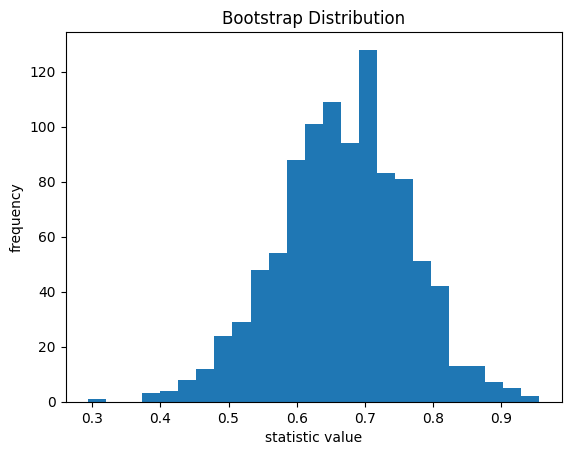

In [ ]:
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

# Save score data

In [ ]:
scored_records_df.to_csv(               "data/02_processed/scored_records_df"+".csv")
scored_records_df.to_excel(             "data/02_processed/scored_records_df"+".xlsx")
scored_records_df.to_pickle(            "data/02_processed/scored_records_df"+".pkl")

aucs_scipy_detailed.to_csv(             "data/02_processed/aucs_scipy_detailed"+".csv")
aucs_scipy_detailed.to_excel(           "data/02_processed/aucs_scipy_detailed"+".xlsx")
aucs_scipy_detailed.to_pickle(          "data/02_processed/aucs_scipy_detailed"+".pkl")

real_roc_curves_scipy.to_csv(           "data/02_processed/real_roc_curves_scipy"+".csv")
real_roc_curves_scipy.to_excel(         "data/02_processed/real_roc_curves_scipy"+".xlsx")
real_roc_curves_scipy.to_pickle(        "data/02_processed/real_roc_curves_scipy"+".pkl")

bootstrapped_aucs_scipy.to_csv(         "data/02_processed/bootstrapped_aucs_scipy"+".csv")
bootstrapped_aucs_scipy.to_excel(       "data/02_processed/bootstrapped_aucs_scipy"+".xlsx")
bootstrapped_aucs_scipy.to_pickle(      "data/02_processed/bootstrapped_aucs_scipy"+".pkl")

bootstrapped_roc_curves_scipy.to_csv(   "data/02_processed/bootstrapped_roc_curves_scipy"+".csv")
bootstrapped_roc_curves_scipy.to_excel( "data/02_processed/bootstrapped_roc_curves_scipy"+".xlsx")
bootstrapped_roc_curves_scipy.to_pickle("data/02_processed/bootstrapped_roc_curves_scipy"+".pkl")


<IPython.core.display.Javascript object>